8


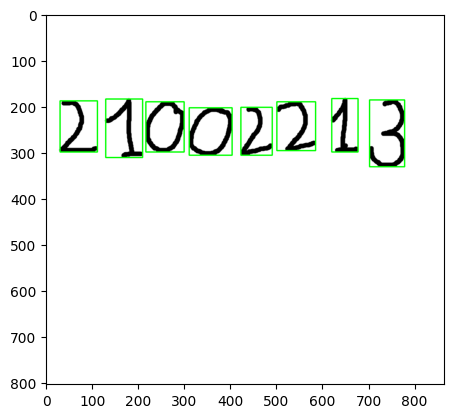

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đọc ảnh và chuyển sang ảnh xám
img = cv2.imread('pic1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_copy = img.copy()

# Làm mờ ảnh để giảm nhiễu
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Phát hiện biên bằng Canny
_,thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)

# Áp dụng phép dãn (dilation) để làm nổi bật các vùng chữ viết
kernel = np.ones((5, 5), np.uint8)
thresh = cv2.dilate(thresh, kernel, iterations=1)

canny = cv2.Canny(thresh, 200, 255)
# Tìm các vùng chứa chữ viết (có thể dùng contour hoặc thresholding)
contours, hierarchy = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Khởi tạo biến đếm số vùng chữ viết
box = 0

# Duyệt qua tất cả các contour
for contour in contours:
    # Tính bounding rectangle cho từng contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Vẽ hình chữ nhật bao quanh contour
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255,0 ), 2)
    
    # Đếm số lượng vùng chữ viết
    box += 1

# In ra số lượng vùng chữ viết
print(box)

# Hiển thị ảnh với các vùng chữ viết được bao quanh
plt.imshow(img_copy)
plt.show()


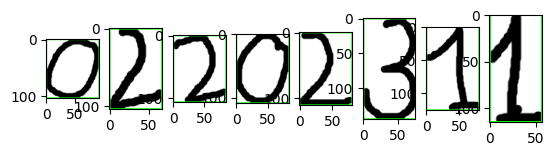

In [23]:
detect = []
for i in range(len(contours)):
    contour = contours[i]
    if hierarchy[0][i][2] == -1:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Xác định các điểm nguồn và điểm đích cho biến đổi hình chiếu
        src_points = np.float32([[x, y], [x + w, y], [x, y + h], [x + w, y + h]])
        dst_points = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
        
        # Tính ma trận biến đổi hình chiếu
        M = cv2.getPerspectiveTransform(src_points, dst_points)
       
        # Thực hiện biến đổi hình chiếu
        warped_number = cv2.warpPerspective(img_copy, M, (w, h))
       
        # Thêm vào danh sách ảnh đã biến đổi
        detect.append(warped_number)
        
        # Vẽ ảnh đã biến đổi vào subplots
        plt.subplot(1, box, i + 1)  # Hiển thị tất cả các ảnh trong 1 dòng
        plt.imshow(warped_number, cmap='gray')
        
      

In [25]:
# Định nghĩa các hàm
def predict(x, w):
    h = np.dot(x, w)
    softmax = np.exp(h - np.max(h, axis=1, keepdims=True))  # Tránh overflow
    y_pred = softmax / np.sum(softmax, axis=1, keepdims=True)
    return y_pred

def loss(x, w, y):
    y_pred = predict(x, w)
    return -np.sum(np.log(y_pred + 1e-10) * y) / y.shape[0]  # Tránh log(0)

def gradient(x, w, y):
    y_pred = predict(x, w)
    delta = y_pred - y
    return np.dot(x.T, delta) / x.shape[0]

def train(x, w, y, lr, epoch):
    for i in range(epoch):
        w -= lr * gradient(x, w, y)
        if i % 10 == 0:  # Hiển thị loss mỗi 10 epoch
            print(f"Epoch {i}, Loss: {loss(x, w, y):.4f}")

In [27]:

import pickle

with open('softmax_weight.pkl', 'rb') as f:
    w_loaded = pickle.load(f)

def classificationSoftMax_img(detect, w_loaded):
    predictions = []
    
    for img in detect:
        # Kiểm tra xem img có phải là mảng NumPy hợp lệ không
        if img is None or not isinstance(img, np.ndarray):
            print("Lỗi: Phần tử không phải là ảnh NumPy hợp lệ.")
            continue
        
        # Chuyển ảnh sang grayscale
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        except cv2.error as e:
            print(f"Lỗi cvtColor: {e}")
            continue
        
        # Tiền xử lý ảnh
        two_color = cv2.inRange(gray, 75, 255)
        two_color = 255 - two_color
        img_resized = cv2.resize(two_color, (56, 56), interpolation=cv2.INTER_CUBIC)
        img_normalized = img_resized / 255.0
        img_flattened = img_normalized.reshape(1, -1)

        # Dự đoán với mô hình softmax đã tải
        y_pred = predict(img_flattened, w_loaded)
        predicted_class = np.argmax(y_pred)  # Lấy lớp có xác suất cao nhất
        predictions.append(predicted_class)
    
    return predictions

predicted_classes = classificationSoftMax_img(detect, w_loaded)
predicted_classes_int = [int(pred) for pred in predicted_classes]
print("Predicted classes:", predicted_classes_int)



Predicted classes: [2, 3, 3, 2, 1, 5, 3, 3]
